In [1]:
# load pandas and read the csv file from the url
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# I don't know why it takes so long to load the data
df = pd.read_csv("./stack-overflow-developer-survey-2024/survey_results_public.csv", )


def basic_info(column):
    print(df[column].head())
    print('-'*40)
    print(df[column].tail())
    print('-'*40)
    print(df[column].isnull().sum())
    print('-'*40)
    print(df[column].value_counts())
    print('-'*40)
    print('*'*40)

# create a value mapping for all categorical data
value_maps = {}
def map_and_fill(column, fill_value=0):
    value_map = {v: i for i, v in enumerate(df[column].dropna().unique())}
    df[column] = df[column].map(value_map)
    df[column] = df[column].fillna(fill_value)
    value_maps[column] = value_map
    return value_map

def reverse_map_and_fill(column):
    if column in value_maps:
        _reverse_map = {v: k for k, v in value_maps[column].items()}
        df[column] = df[column].map(_reverse_map)
    else:
        print(f"No mapping found for column: {column}")

def bin_distribution(column, bins=10,rotate=0):
    plt.figure(figsize=(12,6))
    sns.histplot(df[column], bins=bins, kde=False)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    # rotate x labels
    if rotate:
        plt.xticks(rotation=rotate)
    plt.show()

# don't overthink this function, it is just a fast way to explode a column with multiple values separated by a delimiter and one-hot encode the result, it is for machine learning data cleaning purpose, not for data analysis
def fast_explode(target_dataframe, target_column, fillna='', split=';', prefix='worked with', tmp_column_name='tmp_c'):
    # Step 1: Create a temporary column with split and prefix
    _exploded = (
        target_dataframe.assign(
            **{tmp_column_name: target_dataframe[target_column]
                .fillna(fillna)
                .str.split(split)
                .apply(lambda lst: [f"{prefix} {lang.strip()}" for lang in lst if lang])
            }
        )
        .explode(tmp_column_name)
    )

    # Step 2: One-hot encode
    _one_hot = pd.crosstab(index=_exploded.index, columns=_exploded[tmp_column_name]).astype(bool)

    # Step 3: Combine with original DataFrame
    print(target_column, _one_hot.shape[0], target_dataframe.shape[0])
    result = pd.concat([target_dataframe.drop(columns=[target_column]), _one_hot], axis=1)
    result[_one_hot.columns] = result[_one_hot.columns].fillna(False)

    return result



# let's take a look at the data
print(df.head())
print(df.describe())
print(df.info())

for c in df.columns:
    print(f"{c}")

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

we can see null values throughout all columns, few columns have filled with  full values.

now we will look into the data and see what we can do to clean it up and make it ready for analysis.

In [2]:
# start checking..
basic_info("ResponseId")

# so response_id can be used as index
df.set_index('ResponseId', inplace=True) # setting index

0    1
1    2
2    3
3    4
4    5
Name: ResponseId, dtype: int64
----------------------------------------
65432    65433
65433    65434
65434    65435
65435    65436
65436    65437
Name: ResponseId, dtype: int64
----------------------------------------
0
----------------------------------------
ResponseId
1        1
2        1
3        1
4        1
5        1
        ..
65433    1
65434    1
65435    1
65436    1
65437    1
Name: count, Length: 65437, dtype: int64
----------------------------------------
****************************************


In [3]:
# start checking..
basic_info("MainBranch")

# main_branch seems like a categorical data, asssign the unique values to the value_maps map to interger

print(map_and_fill("MainBranch"))


ResponseId
1    I am a developer by profession
2    I am a developer by profession
3    I am a developer by profession
4             I am learning to code
5    I am a developer by profession
Name: MainBranch, dtype: object
----------------------------------------
ResponseId
65433    I am a developer by profession
65434    I am a developer by profession
65435    I am a developer by profession
65436    I am a developer by profession
65437       I code primarily as a hobby
Name: MainBranch, dtype: object
----------------------------------------
0
----------------------------------------
MainBranch
I am a developer by profession                                                           50207
I am not primarily a developer, but I write code sometimes as part of my work/studies     6511
I am learning to code                                                                     3875
I code primarily as a hobby                                                               3334
I used to be a dev

In [4]:
# it seems like a categorical data, let's see the unique values
print(df['MainBranch'].value_counts())
# ok, its categorical data

MainBranch
0    50207
3     6511
1     3875
2     3334
4     1510
Name: count, dtype: int64


In [5]:
basic_info("Age")
# 0 null values

# mapping the age column
print(map_and_fill("Age"))

ResponseId
1    Under 18 years old
2       35-44 years old
3       45-54 years old
4       18-24 years old
5       18-24 years old
Name: Age, dtype: object
----------------------------------------
ResponseId
65433    18-24 years old
65434    25-34 years old
65435    25-34 years old
65436    18-24 years old
65437    18-24 years old
Name: Age, dtype: object
----------------------------------------
0
----------------------------------------
Age
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64
----------------------------------------
****************************************
{'Under 18 years old': 0, '35-44 years old': 1, '45-54 years old': 2, '18-24 years old': 3, '25-34 years old': 4, '55-64 years old': 5, 'Prefer not to say': 6, '65 years or older': 7}


age is categorical data, we can keep it as it is. But I assume it represented register age/ working experience, not the actual age of the respondents

In [6]:
basic_info("RemoteWork")
# mapping the remote_work column
print(map_and_fill("RemoteWork"))

df['RemoteWork'] = df['RemoteWork'].fillna(0)# filling null values with 0
print(df['RemoteWork'].value_counts())

ResponseId
1    Remote
2    Remote
3    Remote
4       NaN
5       NaN
Name: RemoteWork, dtype: object
----------------------------------------
ResponseId
65433                                  Remote
65434                                  Remote
65435                               In-person
65436    Hybrid (some remote, some in-person)
65437                                     NaN
Name: RemoteWork, dtype: object
----------------------------------------
10631
----------------------------------------
RemoteWork
Hybrid (some remote, some in-person)    23015
Remote                                  20831
In-person                               10960
Name: count, dtype: int64
----------------------------------------
****************************************
{'Remote': 0, 'In-person': 1, 'Hybrid (some remote, some in-person)': 2}
RemoteWork
0.0    31462
2.0    23015
1.0    10960
Name: count, dtype: int64


remote_work is categorical data, we can keep it as it is. And fill the null values with 0, meaning no remote work/experience

In [7]:
basic_info("EdLevel")
# don't know what it is yet, but it seems categorical data, filling null with 0
print(map_and_fill("EdLevel"))
df['EdLevel'] = df['EdLevel'].fillna(0)

ResponseId
1                            Primary/elementary school
2         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
3      Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
4    Some college/university study without earning ...
5    Secondary school (e.g. American high school, G...
Name: EdLevel, dtype: object
----------------------------------------
ResponseId
65433         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65434                                                  NaN
65435         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65436    Secondary school (e.g. American high school, G...
65437                                                  NaN
Name: EdLevel, dtype: object
----------------------------------------
4653
----------------------------------------
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          24942
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       15557
Some college/university study 

In [8]:
basic_info("Check")
# only 1 value drop this column
df.drop(columns=['Check'], inplace=True)

ResponseId
1    Apples
2    Apples
3    Apples
4    Apples
5    Apples
Name: Check, dtype: object
----------------------------------------
ResponseId
65433    Apples
65434    Apples
65435    Apples
65436    Apples
65437    Apples
Name: Check, dtype: object
----------------------------------------
0
----------------------------------------
Check
Apples    65437
Name: count, dtype: int64
----------------------------------------
****************************************


In [9]:
# CodingActivities
basic_info("CodingActivities")
df = fast_explode(df,target_column='CodingActivities', fillna='', split=';', prefix='coding_activities ')



ResponseId
1                                                Hobby
2    Hobby;Contribute to open-source projects;Other...
3    Hobby;Contribute to open-source projects;Other...
4                                                  NaN
5                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
ResponseId
65433                        Hobby;School or academic work
65434             Hobby;Contribute to open-source projects
65435                                                Hobby
65436    Hobby;Contribute to open-source projects;Profe...
65437                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
10971
----------------------------------------
CodingActivities
Hobby                                                                                                                                                                              9993
I 

C:\Users\qswwq\AppData\Local\Temp\ipykernel_54308\4278337842.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[_one_hot.columns] = result[_one_hot.columns].fillna(False)


1    Employed, full-time
2    Employed, full-time
3    Employed, full-time
4     Student, full-time
5     Student, full-time
Name: Employment, dtype: object
----------------------------------------
65433    Employed, full-time
65434    Employed, full-time
65435    Employed, full-time
65436    Employed, full-time
65437     Student, full-time
Name: Employment, dtype: object
----------------------------------------
0
----------------------------------------
Employment
Employed, full-time                                                                                                                                   39041
Independent contractor, freelancer, or self-employed                                                                                                   4846
Student, full-time                                                                                                                                     4709
Employed, full-time;Independent contractor, freelancer, or sel

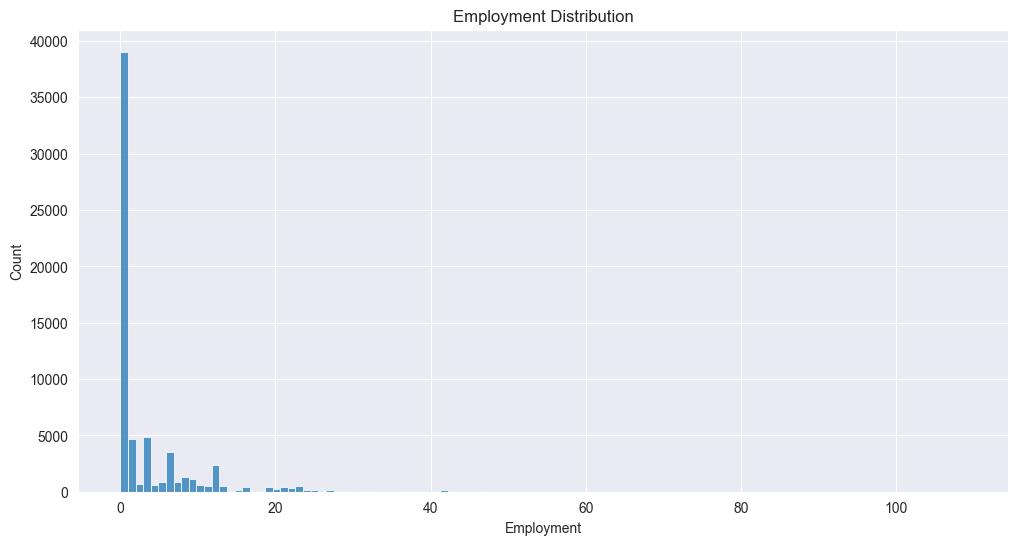

In [10]:
basic_info("Employment")


# mapping the Employment column
print(map_and_fill("Employment"))
df['Employment'] = df['Employment'].fillna(0)
# plot distribution of Employment column

bin_distribution("Employment", bins=len(df['Employment'].unique())+1)



In [11]:
# categorical data, a lot null values
basic_info('LearnCode')
basic_info('LearnCodeOnline')
basic_info('TechDoc')
for col in ['LearnCode', 'LearnCodeOnline', 'TechDoc']:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')


1                               Books / Physical media
2    Books / Physical media;Colleague;On the job tr...
3    Books / Physical media;Colleague;On the job tr...
4    Other online resources (e.g., videos, blogs, f...
5    Other online resources (e.g., videos, blogs, f...
Name: LearnCode, dtype: object
----------------------------------------
65433    On the job training;School (i.e., University, ...
65434                                                  NaN
65435    Other online resources (e.g., videos, blogs, f...
65436    On the job training;Other online resources (e....
65437                                                  NaN
Name: LearnCode, dtype: object
----------------------------------------
4949
----------------------------------------
LearnCode
Other online resources (e.g., videos, blogs, forum, online community)                                                                                                 3674
Books / Physical media;Other online resources (e.g., videos

C:\Users\qswwq\AppData\Local\Temp\ipykernel_54308\4278337842.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[_one_hot.columns] = result[_one_hot.columns].fillna(False)


LearnCodeOnline 49237 65437


C:\Users\qswwq\AppData\Local\Temp\ipykernel_54308\4278337842.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[_one_hot.columns] = result[_one_hot.columns].fillna(False)


TechDoc 40897 65437


C:\Users\qswwq\AppData\Local\Temp\ipykernel_54308\4278337842.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[_one_hot.columns] = result[_one_hot.columns].fillna(False)


1    NaN
2     20
3     37
4      4
5      9
Name: YearsCode, dtype: object
----------------------------------------
65433      5
65434    NaN
65435      9
65436      5
65437    NaN
Name: YearsCode, dtype: object
----------------------------------------
5568
----------------------------------------
YearsCode
10                    4561
5                     3723
6                     3496
8                     3449
7                     3333
4                     3290
15                    2813
20                    2636
12                    2559
3                     2518
9                     2251
14                    1822
25                    1671
2                     1642
11                    1636
13                    1477
30                    1461
16                    1401
18                    1228
17                    1038
40                     993
24                     870
22                     842
35                     735
1                      712
23             

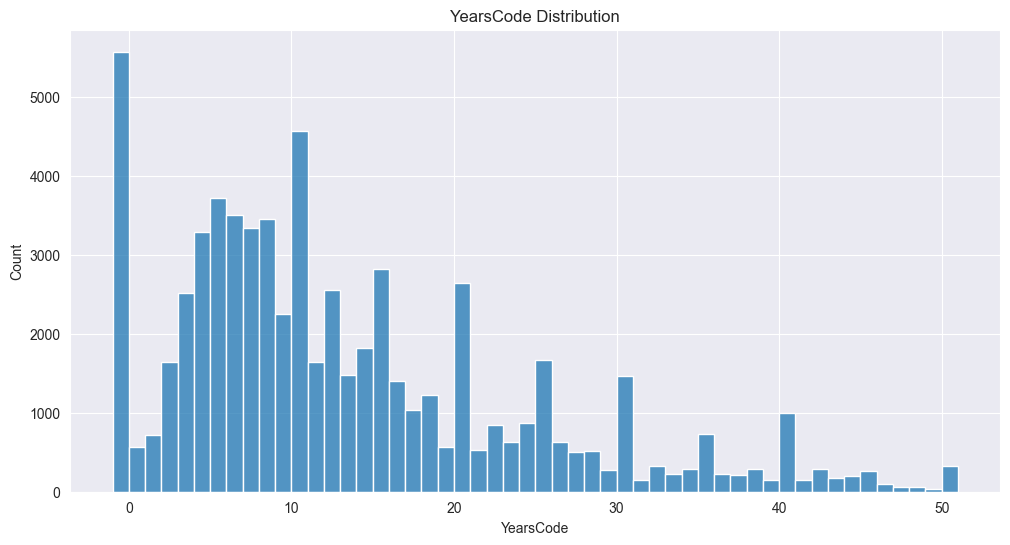

In [12]:
basic_info('YearsCode')
# 2 unique string values 'Less than 1 year' and 'More than 50 years'
# convert them to 0 and 51
df['YearsCode'] = df['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCode")
# need to handle the null values
df['YearsCode'] = df['YearsCode'].fillna(-1)
df['YearsCode'] = df['YearsCode'].astype(int)
bin_distribution('YearsCode', bins=52)

1    NaN
2     17
3     27
4    NaN
5    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
65433      3
65434    NaN
65435      5
65436      2
65437    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
13827
----------------------------------------
YearsCodePro
2                     4168
3                     4093
5                     3526
10                    3251
4                     3215
Less than 1 year      2856
6                     2843
1                     2639
8                     2549
7                     2517
12                    1777
15                    1635
20                    1549
9                     1493
11                    1312
13                    1127
14                    1082
25                     998
16                     946
18                     867
17                     814
30                     689
24                     632
19                     516
22                     492
23   

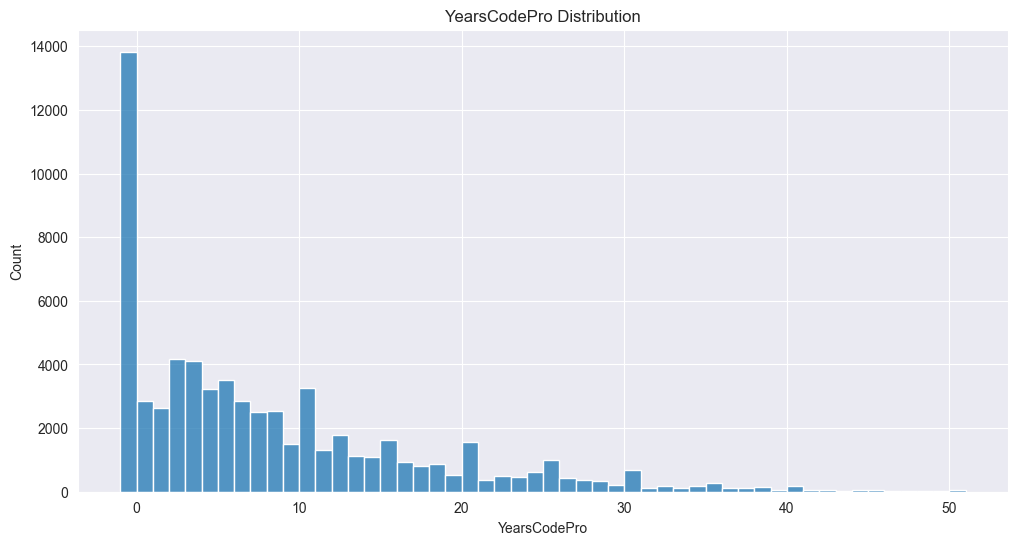

In [13]:
basic_info('YearsCodePro')
df['YearsCodePro'] = df['YearsCodePro'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCodePro")
# need to handle the null values
df['YearsCodePro'] = df['YearsCodePro'].fillna(-1)

df['YearsCodePro'] = df['YearsCodePro'].astype(int)
bin_distribution('YearsCodePro', bins=52)

1                      NaN
2    Developer, full-stack
3     Developer Experience
4    Developer, full-stack
5    Developer, full-stack
Name: DevType, dtype: object
----------------------------------------
65433             Blockchain
65434                    NaN
65435      Developer, mobile
65436    Developer, back-end
65437                    NaN
Name: DevType, dtype: object
----------------------------------------
5992
----------------------------------------
DevType
Developer, full-stack                            18260
Developer, back-end                               9928
Student                                           5102
Developer, front-end                              3349
Developer, desktop or enterprise applications     2493
Other (please specify):                           2458
Developer, mobile                                 2021
Developer, embedded applications or devices       1623
Engineering manager                               1275
Academic researcher            

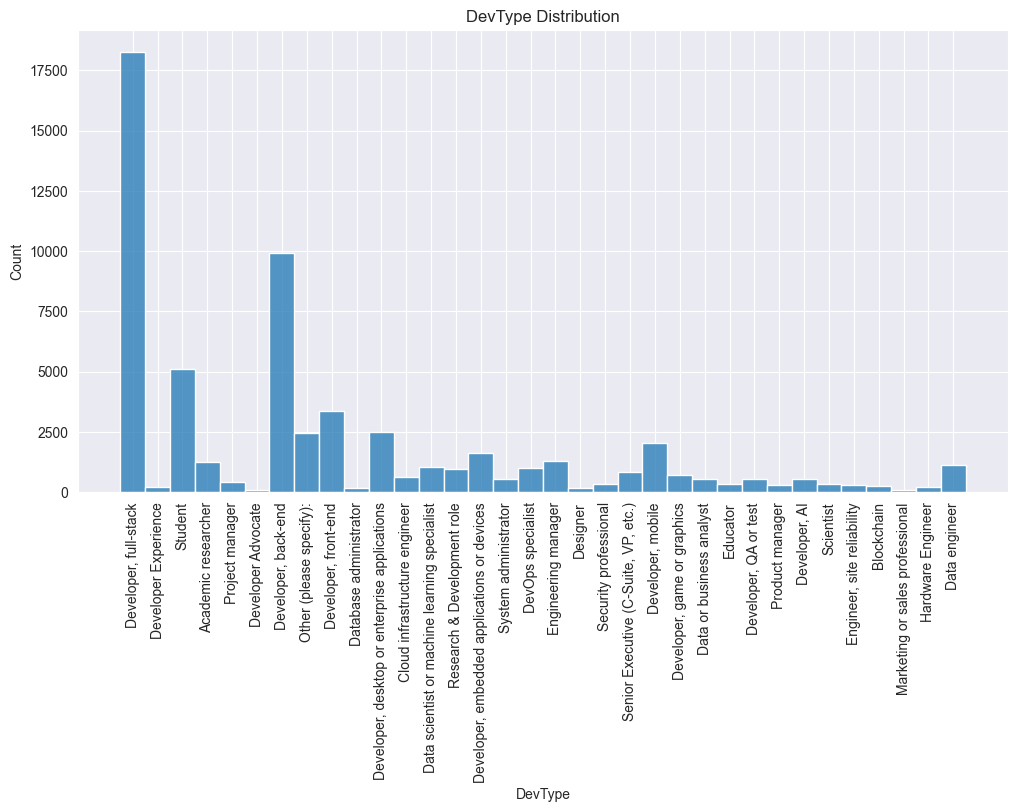

{'Developer, full-stack': 0, 'Developer Experience': 1, 'Student': 2, 'Academic researcher': 3, 'Project manager': 4, 'Developer Advocate': 5, 'Developer, back-end': 6, 'Other (please specify):': 7, 'Developer, front-end': 8, 'Database administrator': 9, 'Developer, desktop or enterprise applications': 10, 'Cloud infrastructure engineer': 11, 'Data scientist or machine learning specialist': 12, 'Research & Development role': 13, 'Developer, embedded applications or devices': 14, 'System administrator': 15, 'DevOps specialist': 16, 'Engineering manager': 17, 'Designer': 18, 'Security professional': 19, 'Senior Executive (C-Suite, VP, etc.)': 20, 'Developer, mobile': 21, 'Developer, game or graphics': 22, 'Data or business analyst': 23, 'Educator': 24, 'Developer, QA or test': 25, 'Product manager': 26, 'Developer, AI': 27, 'Scientist': 28, 'Engineer, site reliability': 29, 'Blockchain': 30, 'Marketing or sales professional': 31, 'Hardware Engineer': 32, 'Data engineer': 33}


In [14]:
basic_info("DevType")
bin_distribution('DevType', bins=df['DevType'].nunique()+1,rotate=90)
print(map_and_fill("DevType"))
df['DevType'] = df['DevType'].fillna(-1)




1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: OrgSize, dtype: object
----------------------------------------
65433            2 to 9 employees
65434                         NaN
65435    1,000 to 4,999 employees
65436          20 to 99 employees
65437                         NaN
Name: OrgSize, dtype: object
----------------------------------------
17957
----------------------------------------
OrgSize
20 to 99 employees                                    9754
100 to 499 employees                                  8694
10,000 or more employees                              5558
1,000 to 4,999 employees                              5353
2 to 9 employees                                      4833
10 to 19 employees                                    4084
500 to 999 employees                                  3183
Just me - I am a freelancer, sole proprietor, etc.    3086
5,000 to 9,999 employees                              1867
I don’t know                                          1068


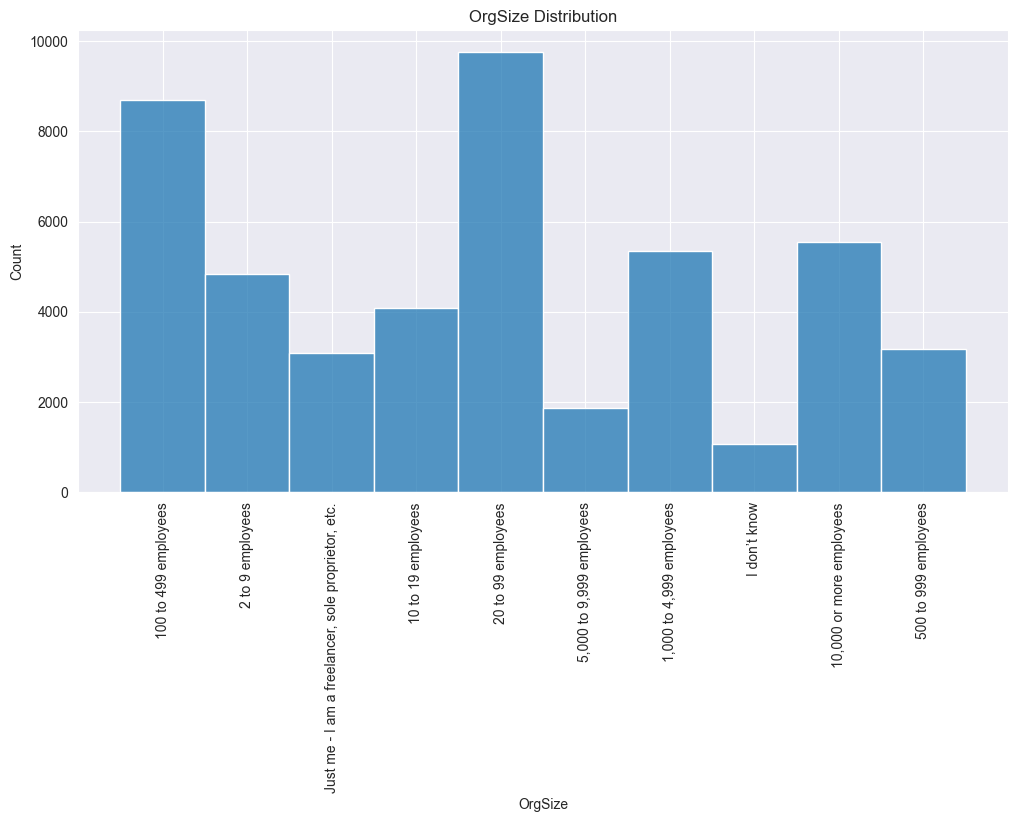

{'100 to 499 employees': 0, '2 to 9 employees': 1, 'Just me - I am a freelancer, sole proprietor, etc.': 2, '10 to 19 employees': 3, '20 to 99 employees': 4, '5,000 to 9,999 employees': 5, '1,000 to 4,999 employees': 6, 'I don’t know': 7, '10,000 or more employees': 8, '500 to 999 employees': 9}


In [15]:
basic_info("OrgSize")
bin_distribution('OrgSize', bins=df['OrgSize'].nunique()+1,rotate=90)
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an organization?
print(map_and_fill("OrgSize"))
df['OrgSize'] = df['OrgSize'].fillna(-1)




In [16]:
basic_info("PurchaseInfluence")
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an influence
print(map_and_fill("PurchaseInfluence"))
df['PurchaseInfluence'] = df['PurchaseInfluence'].fillna(-1)


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
65433            I have some influence
65434                              NaN
65435    I have little or no influence
65436            I have some influence
65437                              NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
18031
----------------------------------------
PurchaseInfluence
I have some influence               19197
I have little or no influence       17942
I have a great deal of influence    10267
Name: count, dtype: int64
----------------------------------------
****************************************
{'I have some influence': 0, 'I have little or no influence': 1, 'I have a great deal of influence': 2}


In [17]:
basic_info("BuyNewTool")# another need to expand categorial data
df = fast_explode(df,target_column='BuyNewTool', fillna='', split=';', prefix='buy_new_tool ')

basic_info('BuildvsBuy')
# don't plot this for the name is so long
# mapping the BuildvsBuy column
print(map_and_fill("BuildvsBuy"))
# filling null values with -1, meaning?
#TODO meaning?
df['BuildvsBuy'] = df['BuildvsBuy'].fillna(-1)



1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: BuyNewTool, dtype: object
----------------------------------------
65433    Ask developers I know/work with;Ask a generati...
65434                                                  NaN
65435    Ask developers I know/work with;Ask a generati...
65436    Start a free trial;Ask developers I know/work ...
65437                                                  NaN
Name: BuyNewTool, dtype: object
----------------------------------------
20256
----------------------------------------
BuyNewTool
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow                                                                            6619
Start a free trial;Ask developers I know/work with                                                                                                                            4927
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow

C:\Users\qswwq\AppData\Local\Temp\ipykernel_54308\4278337842.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[_one_hot.columns] = result[_one_hot.columns].fillna(False)


In [ ]:
basic_info("LanguageHaveWorkedWith")
drop_columns = []
explode_columns = []
for col in df.columns:
    if 'HaveWorkedWith' in col:
        explode_columns.append(col)

    elif  'Admired' in col or 'WantTo' in col or 'SO' in col or 'AI' in col:
        drop_columns.append(col)

print(drop_columns)
print(explode_columns)
# drop first
df.drop(columns=drop_columns, inplace=True)

# expand
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
print(df.isnull().sum())

# Splits each string in LanguageHaveWorkedWith into a list of languages，Creates a new column called Language in the DataFrame. Converts each list in Language into multiple rows.
# df = fast_explode(df,target_column='LanguageHaveWorkedWith', fillna='', split=';', prefix='worked_with ')


In [19]:
basic_info('ICorPM') #Individual Contributor or People Manager
# categorical data, a lot null values, fill null with -1
print(map_and_fill("ICorPM"))
df['ICorPM'] = df['ICorPM'].fillna(-1)



1                       NaN
2    Individual contributor
3                       NaN
4                       NaN
5                       NaN
Name: ICorPM, dtype: object
----------------------------------------
65433                       NaN
65434                       NaN
65435                       NaN
65436    Individual contributor
65437                       NaN
Name: ICorPM, dtype: object
----------------------------------------
35636
----------------------------------------
ICorPM
Individual contributor    25888
People manager             3913
Name: count, dtype: int64
----------------------------------------
****************************************
{'Individual contributor': 0, 'People manager': 1}


In [20]:
basic_info('WorkExp')
# numerical categorical data, a lot null values, fill null with -1
df['WorkExp'] = df['WorkExp'].fillna(-1)

basic_info('Knowledge_1')
# from Knowledge_1 ~9 check the survey question, it is the long question about different things
for i in range(1,10):
    basic_info(f'Knowledge_{i}')
    print(map_and_fill(f'Knowledge_{i}'))
    df[f'Knowledge_{i}'] = df[f'Knowledge_{i}'].fillna(-1)

# Frequency_1 ~ 3 also

for i in range(1,4):
    basic_info(f'Frequency_{i}')
    print(map_and_fill(f'Frequency_{i}'))
    df[f'Frequency_{i}'] = df[f'Frequency_{i}'].fillna(-1)

basic_info('TimeSearching')
print(map_and_fill("TimeSearching"))
df['TimeSearching'] = df['TimeSearching'].fillna(-1)

basic_info('TimeAnswering')
print(map_and_fill("TimeAnswering"))
df['TimeAnswering'] = df['TimeAnswering'].fillna(-1)

basic_info('Frustration')
# change it's name to Challenge_Frustration
df.rename(columns={'Frustration': 'Challenge_Frustration'}, inplace=True)
print(map_and_fill("Challenge_Frustration"))
df['Challenge_Frustration'] = df['Challenge_Frustration'].fillna(-1)


basic_info('ProfessionalTech')
# change name to Company_ProfessionalTech
df.rename(columns={'ProfessionalTech': 'Company_ProfessionalTech'}, inplace=True)
print(map_and_fill("Company_ProfessionalTech"))
df['Company_ProfessionalTech'] = df['Company_ProfessionalTech'].fillna(-1)

basic_info('ProfessionalCloud')
print(map_and_fill("ProfessionalCloud"))
df['ProfessionalCloud'] = df['ProfessionalCloud'].fillna(-1)


basic_info('ProfessionalQuestion')
# change name to FirstAnswer(er)_ProfessionalQuestion
df.rename(columns={'ProfessionalQuestion': 'FirstAnswerer_ProfessionalQuestion'}, inplace=True)
print(map_and_fill("FirstAnswerer_ProfessionalQuestion"))
df['FirstAnswerer_ProfessionalQuestion'] = df['FirstAnswerer_ProfessionalQuestion'].fillna(-1)


basic_info('Industry')
print(map_and_fill("Industry"))
df['Industry'] = df['Industry'].fillna(-1)



1     NaN
2    17.0
3     NaN
4     NaN
5     NaN
Name: WorkExp, dtype: float64
----------------------------------------
65433    NaN
65434    NaN
65435    NaN
65436    5.0
65437    NaN
Name: WorkExp, dtype: float64
----------------------------------------
35779
----------------------------------------
WorkExp
3.0     2144
5.0     2050
10.0    2029
2.0     1885
4.0     1767
6.0     1600
7.0     1581
8.0     1554
1.0     1461
15.0    1250
12.0    1249
20.0    1074
9.0      982
11.0     823
25.0     794
13.0     740
14.0     655
16.0     600
17.0     596
18.0     587
30.0     461
24.0     382
19.0     330
22.0     323
23.0     269
26.0     254
21.0     251
27.0     217
35.0     217
28.0     210
0.0      192
40.0     139
29.0     117
32.0     101
33.0      90
36.0      89
34.0      84
31.0      83
37.0      60
38.0      55
50.0      53
42.0      47
45.0      46
39.0      37
41.0      36
43.0      34
44.0      32
46.0      12
48.0       7
47.0       5
49.0       4
Name: count, dtype: int64

In [21]:
basic_info("TechEndorse")
basic_info("Country") # do keep this for later analysis
basic_info("Currency") # their salary is in this currency
basic_info("CompTotal") # salary! for a year?!
# CompTotal means total compensation, including bonus, etc, not just base salary
# so it is a numerical data
df['CompTotal'] = df['CompTotal'].fillna(0)

print(df['Currency'].unique())
# keep first 3 letters of the currency that is not null

df['Currency'] = df['Currency'].str[:3]
print(df['Currency'].value_counts())
# using gpt to get the currency to usd exchange rate
usd_avg_rates_2024 = {
    "AUD": 1.5158,     # Australian dollar
    "BRL": 5.3872,     # Brazilian real
    "CAD": 1.3699,     # Canadian dollar
    "CNY": 7.1957,     # Chinese Yuan Renminbi
    "DKK": 6.8955,     # Danish krone
    "EUR": 1.0820,     # European Euro
    "HKD": 7.8030,     # Hong Kong dollar
    "INR": 83.6566,    # Indian rupee
    "JPY": 151.4551,   # Japanese yen
    "MYR": 4.5747,     # Malaysian ringgit
    "MXN": 18.3062,    # Mexican peso
    "NZD": 1.6529,     # New Zealand dollar
    "NOK": 10.7574,    # Norwegian krone
    "SGD": 1.3363,     # Singapore dollar
    "ZAR": 18.3346,    # South African rand
    "KRW": 1363.4381,  # South Korean won
    "LKR": 301.6752,   # Sri Lankan rupee
    "SEK": 10.5744,    # Swedish krona
    "CHF": 0.8808,     # Swiss franc
    "TWD": 32.1064,    # New Taiwan dollar
    "THB": 35.2845,    # Thai baht
    "GBP": 1.2781,     # Pound sterling
    "VES": 38.3314     # Venezuelan bolivar
}
# convert all salary to usd
print(df[['CompTotal']].describe())
print(df['CompTotal'].max())

# there are some outliers, let's see how many are above 300000
# remove these outliers using quantile
#TODO apply currency conversion

df = df.loc[(df['CompTotal'] < df['CompTotal'].quantile(0.99)) & (df['CompTotal'] > df['CompTotal'].quantile(0.01))]
#remove salaries below 1000 usd per year ,remove larger than 300000 usd per year



# Example: df['CompTotal'].value_counts()
salary_counts = df['CompTotal'].value_counts()
import plotly.express as px
# Convert to DataFrame
df_salary = salary_counts.reset_index()
df_salary.columns = ['Salary', 'Count']
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=False  # Log scale for better visibility
)

fig.show()
# Plot histogram (weighted by Count)
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram (log scale)',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=True  # Log scale for better visibility
)

fig.show()


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: TechEndorse, dtype: object
----------------------------------------
65433    APIs;Integrated developer community;Quality su...
65434                                                  NaN
65435                                                  NaN
65436    APIs;Customization;Connected to an open source...
65437                                                  NaN
Name: TechEndorse, dtype: object
----------------------------------------
21769
----------------------------------------
TechEndorse
APIs;Customization;Reputation for quality and excellence                                                                                                                           1499
APIs;Customization;Integrated developer community;Quality support system;Reputation for quality and excellence;Frequent updates to features;Connected to an open source project    1227
APIs;Customization;Reputation for quality and excellence;Connected to an open source 

In [22]:
# limit salary to 1000 to 1.5M
df = df.loc[(df['CompTotal'] >= 1000) & (df['CompTotal'] <= 500000)]
print(df[['CompTotal']].describe())


           CompTotal
count   27425.000000
mean   117201.911431
std     96985.286454
min      1000.000000
25%     52000.000000
50%     90000.000000
75%    150000.000000
max    500000.000000


In [23]:
basic_info('JobSatPoints_1')
# JobSatPoints_1~11 need to fillna

# it is an over all job satisfaction score from 1 to 100. total score should be 100 lets check
# !! there is no jsp_2 and jsp_3
# fillna with -1 first
for i in range(1, 12):
    if i in [2,3]:
        continue
    df[f'JobSatPoints_{i}'] = df[f'JobSatPoints_{i}'].fillna(-1)

total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())
# let try to normalize these values to 100, reverse the mistake, round to integer incase accuracy problem
df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].div(total_score[total_score > 100], axis=0).multiply(100)
df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].round().astype(int)








375     NaN
380     0.0
386     NaN
390    10.0
393    40.0
Name: JobSatPoints_1, dtype: float64
----------------------------------------
65397   NaN
65402   NaN
65409   NaN
65413   NaN
65432   NaN
Name: JobSatPoints_1, dtype: float64
----------------------------------------
9315
----------------------------------------
JobSatPoints_1
0.0     6609
10.0    2721
20.0    2006
5.0     1045
30.0     891
        ... 
47.0       1
38.0       1
7.5        1
27.0       1
37.0       1
Name: count, Length: 74, dtype: int64
----------------------------------------
****************************************
 100.0    11991
-9.0       9220
 0.0       2699
 99.0       131
 90.0        79
          ...  
 393.0        1
 273.0        1
 677.0        1
 649.0        1
 271.0        1
Name: count, Length: 417, dtype: int64
2369


In [24]:
total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())

 100    12884
-9       9220
 0       2699
 99       705
 101      483
        ...  
 32         1
 88         1
 23         1
 84         1
-5          1
Name: count, Length: 108, dtype: int64
691


In [25]:
# check null values again
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

TechEndorse              1582
OpSysPersonal use         506
OpSysProfessional use    1877
TBranch                  1516
SurveyLength              971
SurveyEase                930
ConvertedCompYearly      8347
JobSat                   9338
dtype: int64


In [26]:
drop_columns = ['TechEndorse','SurveyLength','SurveyEase','ConvertedCompYearly']
explode_columns = ['OpSysPersonal use','OpSysProfessional use']
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
df.drop(columns=drop_columns, inplace=True)

df['TBranch'] = df['TBranch'].map({'Yes': 1, 'No': 0})
df['TBranch'] = df['TBranch'].fillna(-1)

print(map_and_fill('Country'))
print(map_and_fill('Currency'))


OpSysPersonal use 26919 27425


C:\Users\qswwq\AppData\Local\Temp\ipykernel_49188\4278337842.py:67: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



OpSysProfessional use 25548 27425
{'Austria': 0, 'Turkey': 1, 'France': 2, 'United States of America': 3, 'United Kingdom of Great Britain and Northern Ireland': 4, 'Bulgaria': 5, 'Greece': 6, 'Brazil': 7, 'Germany': 8, 'Italy': 9, 'Ukraine': 10, 'Canada': 11, 'Switzerland': 12, 'Belgium': 13, 'Peru': 14, 'Bolivia': 15, 'Morocco': 16, 'Luxembourg': 17, 'Georgia': 18, 'Saudi Arabia': 19, 'Ireland': 20, 'Romania': 21, 'Spain': 22, 'India': 23, 'Cyprus': 24, 'Paraguay': 25, 'Lithuania': 26, 'Netherlands': 27, 'Slovenia': 28, 'Singapore': 29, 'Pakistan': 30, 'Venezuela, Bolivarian Republic of...': 31, 'Latvia': 32, 'Costa Rica': 33, 'Poland': 34, 'Portugal': 35, 'Finland': 36, 'Israel': 37, 'Nicaragua': 38, 'Czech Republic': 39, 'Serbia': 40, 'Croatia': 41, 'Iran, Islamic Republic of...': 42, 'Bosnia and Herzegovina': 43, 'South Africa': 44, 'Bangladesh': 45, 'Thailand': 46, 'Slovakia': 47, 'El Salvador': 48, 'Ecuador': 49, 'Argentina': 50, 'Malaysia': 51, 'Zimbabwe': 52, 'Afghanistan': 53

C:\Users\qswwq\AppData\Local\Temp\ipykernel_49188\4278337842.py:67: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [27]:
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])
df

JobSat    9338
dtype: int64


,MainBranch,Age,Employment,RemoteWork,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,...,OpSysProfessional use MacOS,OpSysProfessional use Other (please specify):,OpSysProfessional use Other Linux-based,OpSysProfessional use Red Hat,OpSysProfessional use Solaris,OpSysProfessional use Ubuntu,OpSysProfessional use Windows,OpSysProfessional use Windows Subsystem for Linux (WSL),OpSysProfessional use iOS,OpSysProfessional use iPadOS
375,3,4,0,2.0,5.0,12,6,3.0,0.0,1.0,...,False,False,False,False,False,True,True,False,False,False
380,0,1,0,0.0,2.0,15,6,12.0,4.0,2.0,...,True,False,False,False,False,False,False,False,False,False
386,0,1,3,0.0,2.0,27,17,6.0,2.0,2.0,...,True,False,False,False,False,False,False,False,False,False
390,0,4,5,0.0,3.0,7,7,2.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,False
393,0,1,0,2.0,5.0,32,18,17.0,6.0,1.0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65397,0,3,6,2.0,4.0,3,3,0.0,6.0,1.0,...,False,False,False,False,False,False,False,False,False,False
65402,0,4,0,2.0,1.0,10,7,0.0,4.0,2.0,...,False,False,True,False,False,False,True,False,False,False
65409,0,4,0,2.0,2.0,13,9,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
65413,0,1,0,0.0,1.0,20,18,6.0,0.0,1.0,...,True,False,False,False,False,False,False,False,False,False


In [28]:
df.replace({True: 1, False: 0}, inplace=True)
# df

C:\Users\qswwq\AppData\Local\Temp\ipykernel_49188\2350222389.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [29]:
# start model prediction using xgboost or lightgbm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# --- Candidate models ---
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ahh.. standard scaler
# ========== 1. Data preparation ==========
# Filter and clean
# using country and currency as grouping then separate the data into train_df

# train_df = df.loc[df["CompTotal"] >= 1000].copy()
# train_df.drop(columns=["JobSat"], errors="ignore", inplace=True)
#
# # Split features and target
# X = train_df.drop(columns=["CompTotal"])
# y = train_df["CompTotal"]
#
# # Split into training / testing
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )
#
# # ========== 2. Preprocessing pipeline ==========
# # Identify numeric and categorical columns
# num_cols = X_train.select_dtypes(include=["number"]).columns
# cat_cols = X_train.select_dtypes(exclude=["number"]).columns
#
# # Numeric pipeline
# numeric_pipeline = Pipeline(steps=[
#
#     ("scaler", StandardScaler())
# ])
#
#
#
# # Combine into column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_pipeline, num_cols),
#
#     ]
# )
#
# # ========== 3. Define models ==========
# models = {
#     "GradientBoosting": GradientBoostingRegressor(
#         n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
#     ),
#     "RandomForest": RandomForestRegressor(
#         n_estimators=400, random_state=42, n_jobs=-1
#     ),
#     "HistGradientBoosting": HistGradientBoostingRegressor(
#         learning_rate=0.05, random_state=42
#     )
# }
#
#
# models["XGBoost"] = XGBRegressor(
#     n_estimators=600, learning_rate=0.05, max_depth=6,
#     subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
# )
#
#
# models["LightGBM"] = LGBMRegressor(
#     n_estimators=600, learning_rate=0.05, num_leaves=31,
#     subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
# )
#
# # ========== 4. Evaluate each model with cross-validation ==========
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# results = []
#
# for name, model in models.items():
#     pipe = Pipeline(steps=[("preprocessor", preprocessor),
#                            ("model", model)])
#     scores = cross_val_score(
#         pipe, X_train, y_train,
#         scoring="neg_root_mean_squared_error",
#         cv=cv, n_jobs=-1,error_score='raise'
#     )
#     rmse = -scores.mean()
#     print(f"{name:>20s} | CV RMSE: {rmse:.2f}")
#     results.append((name, rmse, scores.std()))
#
# # Sort and select best
# results_df = pd.DataFrame(results, columns=["Model", "CV_RMSE", "Std"]).sort_values("CV_RMSE")
# best_model_name = results_df.iloc[0]["Model"]
# print("\nBest model:", best_model_name)
#
# # ========== 5. Fit best model pipeline and evaluate on test set ==========
# best_model = models[best_model_name]
# best_pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", best_model)
# ])
#
# best_pipeline.fit(X_train, y_train)
# y_pred = best_pipeline.predict(X_test)
#
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae  = mean_absolute_error(y_test, y_pred)
# r2   = r2_score(y_test, y_pred)
#
# print(f"\n--- Test Performance ({best_model_name}) ---")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE : {mae:.2f}")
# print(f"R²  : {r2:.4f}")
#
# # Optional: show model comparison table
# print("\nModel comparison (lower RMSE better):")
# print(results_df.to_string(index=False))




In [30]:
# lightbgm seems to be the best model here, check feature importance and plot the top 20 features

# feature_names_num = num_cols.tolist()
#
# feature_names = feature_names_num
#
# importances = best_model.feature_importances_
# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)
#
# print("\nTop 20 Feature Importances:")
# print(feature_importance_df.head(20))
#
# # Plot top 20 features
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
# plt.title('Top 20 Feature Importances')
# plt.tight_layout()
# plt.show()

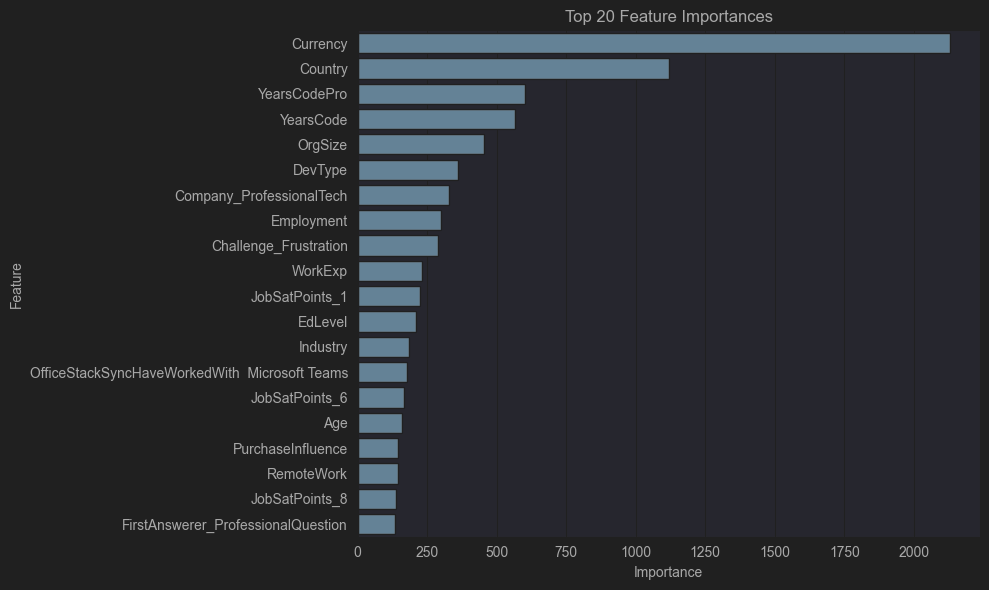
# first modelling is terrible, we need a deeper analysis of the data.
# we can see that the country and currency are important features, we can try to group the data by country and currency and see what we can find out.

In [31]:
for train_df in df.groupby(['Country', 'Currency']):
    print(train_df[0], train_df[1].shape)

(np.int64(0), np.int64(0)) (488, 477)
(np.int64(0), np.int64(1)) (2, 477)
(np.int64(0), np.int64(10)) (1, 477)
(np.int64(1), np.int64(0)) (11, 477)
(np.int64(1), np.int64(1)) (39, 477)
(np.int64(1), np.int64(2)) (1, 477)
(np.int64(1), np.int64(9)) (78, 477)
(np.int64(1), np.int64(31)) (1, 477)
(np.int64(2), np.int64(0)) (1304, 477)
(np.int64(2), np.int64(1)) (2, 477)
(np.int64(2), np.int64(3)) (1, 477)
(np.int64(2), np.int64(6)) (7, 477)
(np.int64(3), np.int64(1)) (6880, 477)
(np.int64(3), np.int64(13)) (1, 477)
(np.int64(3), np.int64(32)) (1, 477)
(np.int64(3), np.int64(35)) (1, 477)
(np.int64(3), np.int64(79)) (2, 477)
(np.int64(4), np.int64(0)) (2, 477)
(np.int64(4), np.int64(1)) (9, 477)
(np.int64(4), np.int64(2)) (1978, 477)
(np.int64(4), np.int64(33)) (1, 477)
(np.int64(4), np.int64(106)) (2, 477)
(np.int64(5), np.int64(0)) (3, 477)
(np.int64(5), np.int64(1)) (7, 477)
(np.int64(5), np.int64(2)) (1, 477)
(np.int64(5), np.int64(21)) (148, 477)
(np.int64(5), np.int64(70)) (1, 477)
(

# we can see that some country and currency have very few data, we can filter out these data and only keep the country and currency with more than 1000 data points.


In [32]:
# finding the country and currency with more than 1000 data points
for train_df in df.groupby(['Country', 'Currency']):
    if train_df[1].shape[0]>1000:
        print(train_df[0], train_df[1].shape)
        for x in value_maps['Country'].keys() :
            if value_maps['Country'][x]==train_df[0][0]:
                print(x)

        for x in value_maps['Currency'].keys() :
            if value_maps['Currency'][x]==train_df[0][1]:
                print(x)
# and it's USA and USD, France and EUR,  UK and GBP, Canada and CAD, Germany and EUR

(np.int64(2), np.int64(0)) (1304, 477)
France
EUR
(np.int64(3), np.int64(1)) (6880, 477)
United States of America
USD
(np.int64(4), np.int64(2)) (1978, 477)
United Kingdom of Great Britain and Northern Ireland
GBP
(np.int64(8), np.int64(0)) (2972, 477)
Germany
EUR
(np.int64(11), np.int64(3)) (1237, 477)
Canada
CAD


    Components  ExplainedVariance
0            1           0.034639
1            2           0.058752
2            3           0.080626
3            4           0.100431
4            5           0.114995
..         ...                ...
94          95           0.470120
95          96           0.472636
96          97           0.475141
97          98           0.477626
98          99           0.480088

[99 rows x 2 columns]


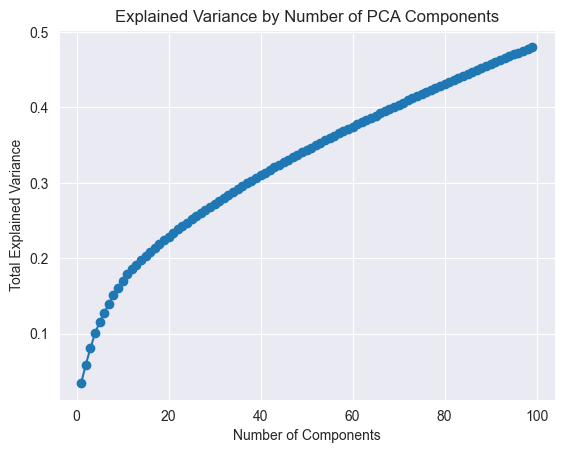

In [38]:
# select these country and currency  ,3 and 1
df_cleaned = df.loc[df["CompTotal"] >= 1000].copy()
df_cleaned.drop(columns=["JobSat"], errors="ignore", inplace=True)
df_cleaned = df_cleaned[((df_cleaned['Country']==value_maps['Country']['United States of America']) & (df_cleaned['Currency']==value_maps['Currency']['USD']))
                        ]

from sklearn.decomposition import PCA

results = []
for group in df_cleaned.groupby(['Country', 'Currency']):
    train_df = group[1]
    if train_df.shape[0]<1000:
        continue
# --- 1️⃣ Prepare data ---
# Assuming df_cleaned is your cleaned DataFrame with only numeric columns
    X = train_df.select_dtypes(include=['number'])

    # --- 2️⃣ Standardize the features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- 3️⃣ Apply PCA ---
    # Let's start with 2 principal components for visualization
    for n in range(1, 100):
        pca = PCA(n_components=n)
        pca.fit(X_scaled)
        results.append({'Components': n, 'ExplainedVariance': pca.explained_variance_ratio_.sum()})

    pca_summary = pd.DataFrame(results)
    print(pca_summary)
    plt.plot(pca_summary['Components'], pca_summary['ExplainedVariance'], marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Total Explained Variance')
    plt.title('Explained Variance by Number of PCA Components')
    plt.grid(True)
    plt.show()


    GradientBoosting | CV RMSE: 25496.22
        RandomForest | CV RMSE: 25170.80
HistGradientBoosting | CV RMSE: 25254.36
             XGBoost | CV RMSE: 25147.70
            LightGBM | CV RMSE: 25736.40

Best model: XGBoost

--- Test Performance (XGBoost) ---
RMSE: 27999.24
MAE : 17544.87
R²  : 0.2137

Model comparison (lower RMSE better):
               Model      CV_RMSE         Std
             XGBoost 25147.704785 2924.025317
        RandomForest 25170.802974 3036.293508
HistGradientBoosting 25254.355634 2648.286957
    GradientBoosting 25496.223737 3139.568396
            LightGBM 25736.398139 2455.650891
EUR
****************************************
****************************************

Top 20 Feature Importances:
                                               Feature  Importance
394                 OfficeStackSyncHaveWorkedWith  IRC    0.020897
246                  EmbeddedHaveWorkedWith  Micronaut    0.020615
417                  AISearchDevHaveWorkedWith  Claude    0.0185

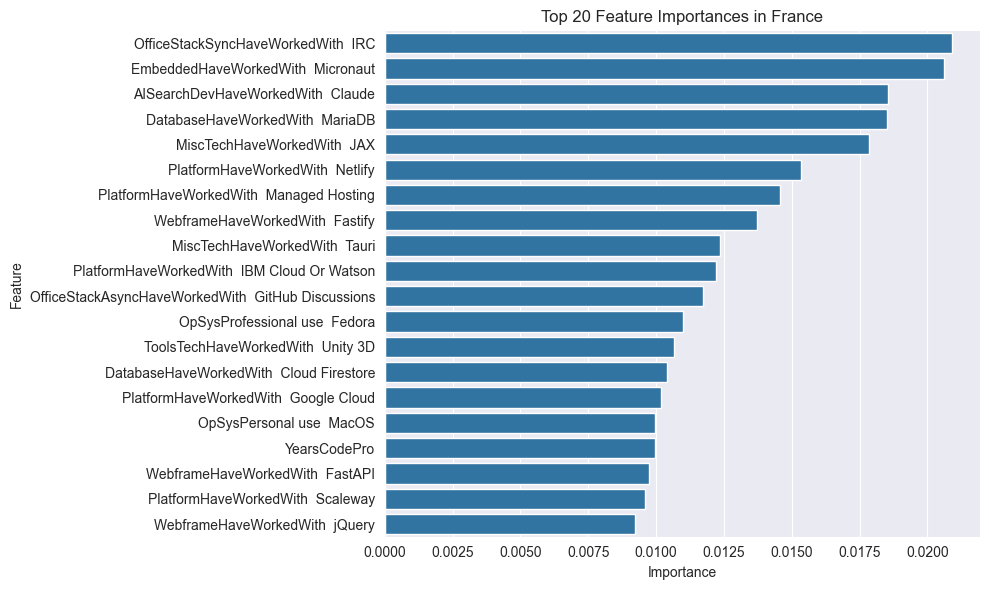

    GradientBoosting | CV RMSE: 44468.45
        RandomForest | CV RMSE: 45618.97
HistGradientBoosting | CV RMSE: 43766.51
             XGBoost | CV RMSE: 43491.01
            LightGBM | CV RMSE: 43218.98

Best model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 5256, number of used features: 445
[LightGBM] [Info] Start training from score 146266.471081


E:\Projects\AAU_Projects\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names




--- Test Performance (LightGBM) ---
RMSE: 43805.74
MAE : 33321.31
R²  : 0.4599

Model comparison (lower RMSE better):
               Model      CV_RMSE        Std
            LightGBM 43218.976453 856.461970
             XGBoost 43491.011284 949.970241
HistGradientBoosting 43766.512776 701.416182
    GradientBoosting 44468.454404 679.251521
        RandomForest 45618.965385 476.208844
USD
****************************************
****************************************

Top 20 Feature Importances:
                                            Feature  Importance
6                                      YearsCodePro         689
8                                           OrgSize         574
5                                         YearsCode         569
31                         Company_ProfessionalTech         483
7                                           DevType         481
30                            Challenge_Frustration         398
34                                         Indus

E:\Projects\AAU_Projects\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names




--- Test Performance (LightGBM) ---
RMSE: 43805.74
MAE : 33321.31
R²  : 0.4599

Model comparison (lower RMSE better):
               Model      CV_RMSE        Std
            LightGBM 43218.976453 856.461970
             XGBoost 43491.011284 949.970241
HistGradientBoosting 43766.512776 701.416182
    GradientBoosting 44468.454404 679.251521
        RandomForest 45618.965385 476.208844
USD
****************************************
****************************************

Top 20 Feature Importances (all features):
                                            Feature  Importance
6                                      YearsCodePro         689
8                                           OrgSize         574
5                                         YearsCode         569
31                         Company_ProfessionalTech         483
7                                           DevType         481
30                            Challenge_Frustration         398
34                               

E:\Projects\AAU_Projects\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names




=== Top-50 Feature Refit (LightGBM) in United States of America [USD] ===
BEFORE  -> RMSE: 43805.74 | MAE: 33321.31 | R²: 0.4599  (all 475 numeric features)
AFTER   -> RMSE: 44944.17 | MAE: 34548.96 | R²: 0.4315  (top 50 features)
ΔRMSE (top-50 - all): +1138.43


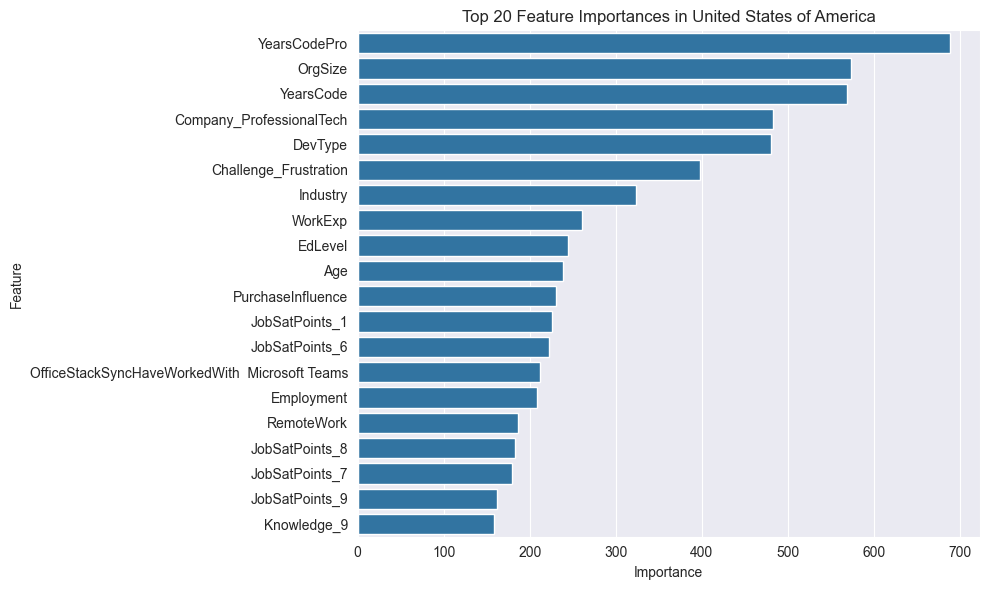

    GradientBoosting | CV RMSE: 33684.22
        RandomForest | CV RMSE: 34334.85
HistGradientBoosting | CV RMSE: 33086.39
             XGBoost | CV RMSE: 32503.95
            LightGBM | CV RMSE: 32633.06

Best model: XGBoost

--- Test Performance (XGBoost) ---
RMSE: 30376.02
MAE : 21626.69
R²  : 0.4336

Model comparison (lower RMSE better):
               Model      CV_RMSE         Std
             XGBoost 32503.952249  666.753464
            LightGBM 32633.062433  793.076592
HistGradientBoosting 33086.394733  961.407344
    GradientBoosting 33684.224973 1169.760418
        RandomForest 34334.847963  759.452971
GBP
****************************************
****************************************

Top 20 Feature Importances:
                                            Feature  Importance
145               DatabaseHaveWorkedWith  Couchbase    0.019253
423              AISearchDevHaveWorkedWith  Meta AI    0.018048
404         OfficeStackSyncHaveWorkedWith  Symphony    0.014252
245      

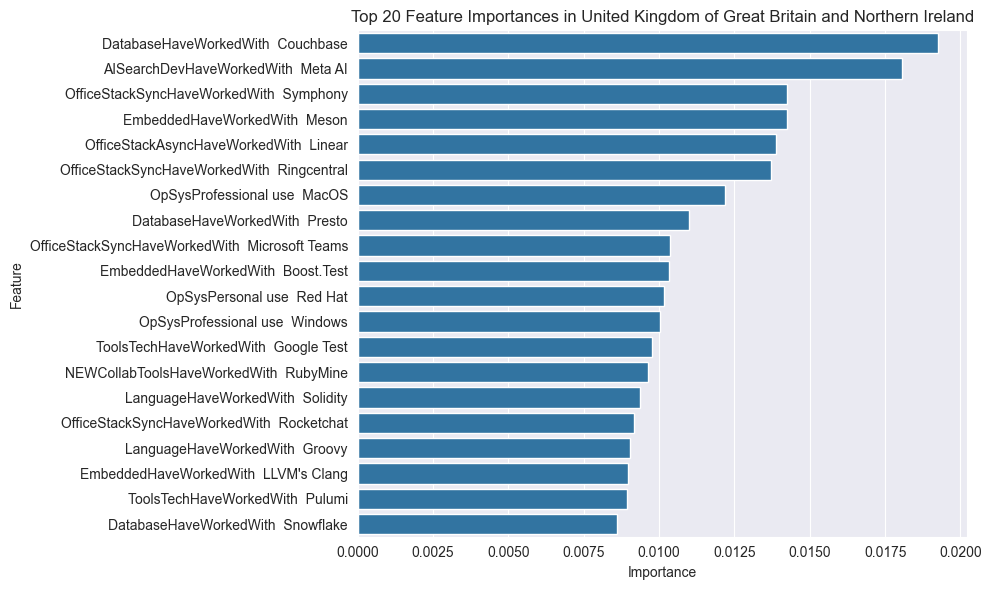

    GradientBoosting | CV RMSE: 27036.35
        RandomForest | CV RMSE: 27340.84
HistGradientBoosting | CV RMSE: 26299.64
             XGBoost | CV RMSE: 26050.19
            LightGBM | CV RMSE: 26372.26

Best model: XGBoost

--- Test Performance (XGBoost) ---
RMSE: 22574.87
MAE : 15064.41
R²  : 0.4762

Model comparison (lower RMSE better):
               Model      CV_RMSE         Std
             XGBoost 26050.186903 1441.041835
HistGradientBoosting 26299.643373 1600.015139
            LightGBM 26372.263883 1349.049433
    GradientBoosting 27036.347568 1322.608622
        RandomForest 27340.837374 1460.906098
EUR
****************************************
****************************************

Top 20 Feature Importances:
                                               Feature  Importance
434               AISearchDevHaveWorkedWith  Whispr AI    0.028386
440                             OpSysPersonal use  BSD    0.028385
199                      PlatformHaveWorkedWith  Vultr    0.0266

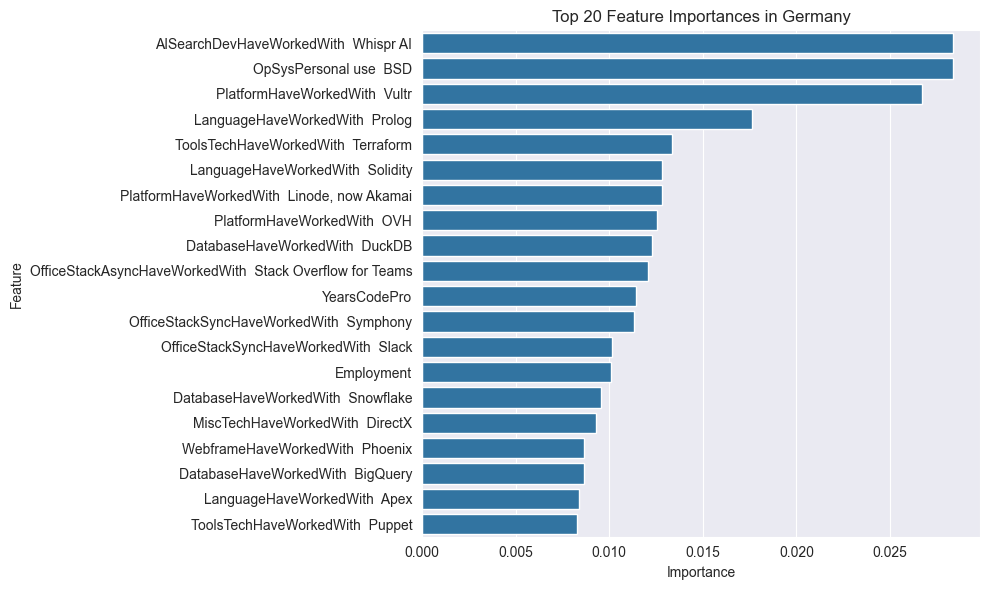

    GradientBoosting | CV RMSE: 43977.94
        RandomForest | CV RMSE: 44815.55
HistGradientBoosting | CV RMSE: 44118.37
             XGBoost | CV RMSE: 44148.17
            LightGBM | CV RMSE: 44856.83

Best model: GradientBoosting

--- Test Performance (GradientBoosting) ---
RMSE: 41332.02
MAE : 31771.10
R²  : 0.4177

Model comparison (lower RMSE better):
               Model      CV_RMSE         Std
    GradientBoosting 43977.939388 1326.487811
HistGradientBoosting 44118.368637 1486.742584
             XGBoost 44148.171496 1351.728062
        RandomForest 44815.552309 1201.191135
            LightGBM 44856.833039 1337.290858
CAD
****************************************
****************************************

Top 20 Feature Importances:
                                            Feature  Importance
6                                      YearsCodePro    0.305766
8                                           OrgSize    0.054786
465                    OpSysProfessional use  MacOS    

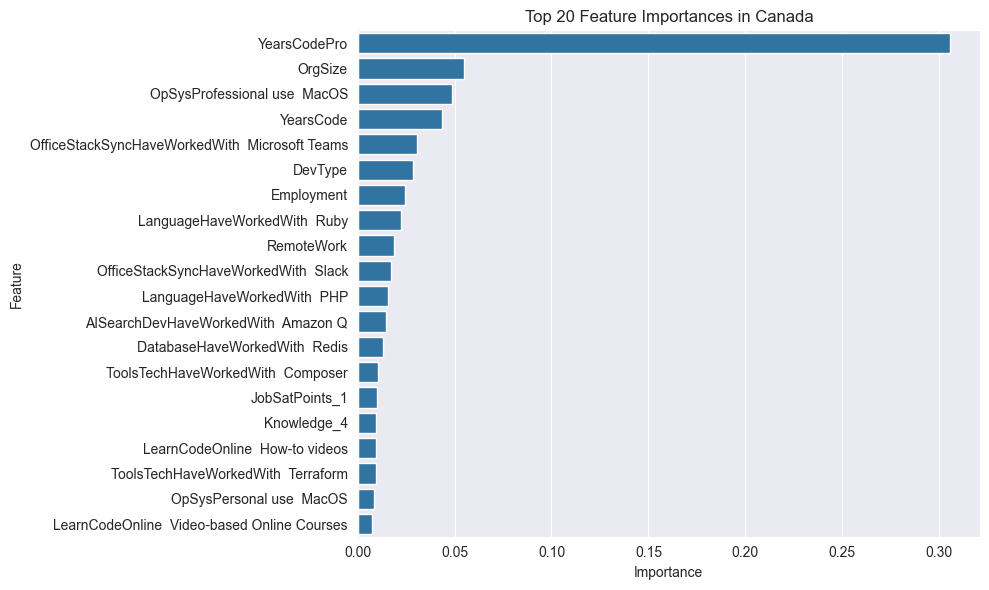

In [39]:
                                                                                                                                                                                                                                           from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import numpy as np
# --- baseline models ---
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
# kaggle top models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ========== 1. Data preparation ==========

df_cleaned = df.loc[df["CompTotal"] >= 1000].copy()
df_cleaned = df_cleaned.loc[df["CompTotal"] <= 300000].copy()

df_cleaned.drop(columns=["JobSat"], errors="ignore", inplace=True)

for group in df_cleaned.groupby(['Country', 'Currency']):
    train_df = group[1]
    if train_df.shape[0]<1000:
        continue
    # Split features and target
    X = train_df.drop(columns=["CompTotal"])
    y = train_df["CompTotal"]

    # Split into training / testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ========== 2. Preprocessing pipeline ==========
    # Identify numeric and categorical columns
    num_cols = X_train.select_dtypes(include=["number"]).columns
    cat_cols = X_train.select_dtypes(exclude=["number"]).columns

    # Numeric pipeline
    numeric_pipeline = Pipeline(steps=[

        ("scaler", StandardScaler())
    ])



    # Combine into column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, num_cols),

        ]
    )

    # ========== 3. Define models ==========
    models = {
        "GradientBoosting": GradientBoostingRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
        ),
        "RandomForest": RandomForestRegressor(
            n_estimators=400, random_state=42, n_jobs=-1
        ),
        "HistGradientBoosting": HistGradientBoostingRegressor(
            learning_rate=0.05, random_state=42
        )
    }


    models["XGBoost"] = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
    )


    models["LightGBM"] = LGBMRegressor(
        n_estimators=600, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
    )

    # ========== 4. Evaluate each model with cross-validation ==========
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in models.items():
        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])
        scores = cross_val_score(
            pipe, X_train, y_train,
            scoring="neg_root_mean_squared_error",
            cv=cv, n_jobs=-1,error_score='raise'
        )
        rmse = -scores.mean()
        print(f"{name:>20s} | CV RMSE: {rmse:.2f}")
        results.append((name, rmse, scores.std()))

    # Sort and select best
    results_df = pd.DataFrame(results, columns=["Model", "CV_RMSE", "Std"]).sort_values("CV_RMSE")
    best_model_name = results_df.iloc[0]["Model"]
    print("\nBest model:", best_model_name)

    # ========== 5. Fit best model pipeline and evaluate on test set ==========
    best_model = models[best_model_name]
    best_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", best_model)
    ])

    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"\n--- Test Performance ({best_model_name}) ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

    # Optional: show model comparison table
    print("\nModel comparison (lower RMSE better):")
    print(results_df.to_string(index=False))
    _country = ''
    for x in value_maps['Country'].keys() :
        if value_maps['Country'][x]==group[0][0]:
            _country = x

    for x in value_maps['Currency'].keys() :
        if value_maps['Currency'][x]==group[0][1]:
            print(x)
    print('*'*40)
    print('*'*40)
    feature_names_num = num_cols.tolist()

    feature_names = feature_names_num

    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 20 Feature Importances:")
    print(feature_importance_df.head(20))
       # ---------- existing code up to the first evaluation ----------
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"\n--- Test Performance ({best_model_name}) ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

    print("\nModel comparison (lower RMSE better):")
    print(results_df.to_string(index=False))

    # --------- Nice labels for Country/Currency (unchanged) ---------
    _country = ''
    for x in value_maps['Country'].keys():
        if value_maps['Country'][x] == group[0][0]:
            _country = x

    _currency = ''
    for x in value_maps['Currency'].keys():
        if value_maps['Currency'][x] == group[0][1]:
            _currency = x
    print(_currency)
    print('*'*40)
    print('*'*40)

    # ===================== TOP-50 FEATURE REFIT =====================
    # 1) Get feature importances (fallback to permutation importance if needed)
    feature_names = num_cols.tolist()  # only numeric used in your preprocessor
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
    else:
        # Fallback: permutation importance on training set
        # (uses the full pipeline so it handles scaling correctly)
        perm = permutation_importance(
            best_pipeline, X_train, y_train,
            n_repeats=5,
            scoring="neg_root_mean_squared_error",
            random_state=42,
            n_jobs=-1
        )
        # With your current preprocessor (only numeric), importances align to feature_names
        importances = perm.importances_mean

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 20 Feature Importances (all features):")
    print(feature_importance_df.head(20))

    # 2) Pick top-K features
    TOP_K = min(50, len(feature_names))
    top_features = feature_importance_df.head(TOP_K)['Feature'].tolist()

    # 3) Build a new preprocessor that only uses the top-K features
    preprocessor_top = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, top_features),
        ]
    )

    # 4) Clone the best model (clean, unfitted) and retrain on top-K
    best_model_top = clone(best_model)
    best_pipeline_top = Pipeline(steps=[
        ("preprocessor", preprocessor_top),
        ("model", best_model_top)
    ])
    best_pipeline_top.fit(X_train, y_train)
    y_pred_top = best_pipeline_top.predict(X_test)

    rmse_top = np.sqrt(mean_squared_error(y_test, y_pred_top))
    mae_top  = mean_absolute_error(y_test, y_pred_top)
    r2_top   = r2_score(y_test, y_pred_top)

    # 5) Report before/after
    print(f"\n=== Top-{TOP_K} Feature Refit ({best_model_name}) in {_country} [{_currency}] ===")
    print(f"BEFORE  -> RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}  (all {len(feature_names)} numeric features)")
    print(f"AFTER   -> RMSE: {rmse_top:.2f} | MAE: {mae_top:.2f} | R²: {r2_top:.4f}  (top {TOP_K} features)")
    delta = rmse_top - rmse
    print(f"ΔRMSE (top-{TOP_K} - all): {delta:+.2f}")

    # Optional: plot top 20 features among the selected set (from original ranking)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances in {_country}')
    plt.tight_layout()
    plt.show()
    # # Plot top 20 features
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    # plt.title(f'Top 20 Feature Importances in {_country}')
    # plt.tight_layout()
    # plt.show()
    #



In [ ]:
# using top 30 feature the train again
